In [53]:
import numpy as np
import matplotlib.pyplot as plt

In [54]:
from dataclasses import dataclass

MAX_SPD = 120
MIN_SPD = 0
MAX_POS_ABS = 360
MAX_DELAY = 0.1
MIN_DELAY = 0.005
ERR = 0.6
def linear_mapper(x:float, x_min:float, x_max:float, y_min:float, y_max:float) -> float:
    import math
    # Clamp the absolute value of 'x' within the specified range [x_min, x_max]
    abs_x = abs(x)
    clamped_x = max(min(abs_x, x_max), x_min)

    # Scale the clamped absolute value 'x' to the range [0, 1]
    scaled_x = (clamped_x - x_min) / (x_max - x_min)

    mapped_y = scaled_x

    # Scale the mapped 'y' value to the range [y_min, y_max]
    scaled_y = y_min + (mapped_y * (y_max - y_min))
    return scaled_y

@dataclass
class ExtremumParams:
    x_min:float
    x_max:float
    y_min:float
    y_max:float

@dataclass
class PiecewiseLinearParams:
    alpha:float
    alpha_slope:float
    beta_slope:float
    gamma_slope:float

def piecewise_linear_mapper(x:float, extremum:ExtremumParams, piecewise:PiecewiseLinearParams) -> float:
    import math
    # Clamp the absolute value of 'x' within the specified range [x_min, x_max]
    x_max = extremum.x_max
    x_min = extremum.x_min
    y_max = extremum.y_max
    y_min = extremum.y_min

    scaled_alpha = linear_mapper(piecewise.alpha, x_min, x_max, 0, 1)

    abs_x = abs(x)
    clamped_x = max(min(abs_x, x_max), x_min)

    # Scale the clamped absolute value 'x' to the range [0, 1]
    scaled_x = (clamped_x - x_min) / (x_max - x_min)

    mapped_y:float
    alpha_y = scaled_alpha * piecewise.alpha_slope
    
    # Calculate the mapped 'y' value based on the piecewise segments
    if scaled_x < scaled_alpha:
        mapped_y = scaled_x * piecewise.alpha_slope
    else:
        def line_gamma(x:float) -> float:
            return (x - scaled_alpha) * piecewise.gamma_slope + alpha_y
        def line_beta(x:float) -> float:
            return (x - 1) * piecewise.beta_slope + 1
        # find the point where the two lines intersect
        # gamma is 2
        # beta is 1
        y_2 = alpha_y
        y_1 = 1
        x_2 = scaled_alpha
        x_1 = 1
        k_1 = piecewise.beta_slope
        k_2 = piecewise.gamma_slope
        beta_x = (y_2 - y_1 + k_1 * x_1 - k_2 * x_2) / (k_1 - k_2)
        if scaled_x < beta_x:
            mapped_y = line_gamma(scaled_x)
        else:
            mapped_y = line_beta(scaled_x)

    # Scale the mapped 'y' value to the range [y_min, y_max]
    scaled_y = y_min + (mapped_y * (y_max - y_min))
    return scaled_y


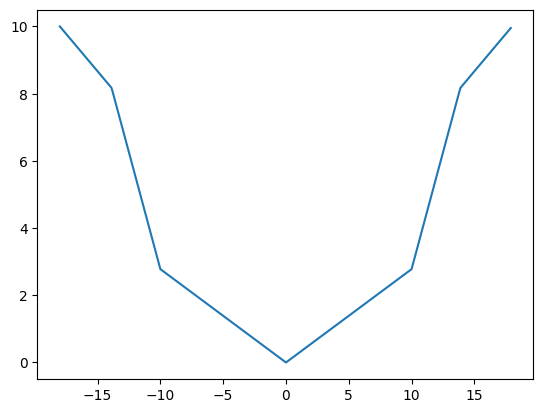

In [55]:
# ex = ExtremumParams(0, MAX_POS_ABS, MIN_SPD, MAX_SPD)
# piece = PiecewiseLinearParams(30, 0.3, 0.25, 2)
MAX_POS_ABS_PRIME = 18
xs = np.arange(-MAX_POS_ABS_PRIME, MAX_POS_ABS_PRIME, 0.1)
ex = ExtremumParams(0, MAX_POS_ABS_PRIME, 0, 10)
piece = PiecewiseLinearParams(10, 0.5, 0.8, 2.5)
# mapper = lambda x: linear_mapper(x, 0, MAX_POS_ABS, MIN_SPD, MAX_SPD)
mapper = lambda x: piecewise_linear_mapper(x, ex, piece)
ys = list(map(lambda y: mapper(y), xs))
plt.plot(xs, ys)